# LSTM for Smoothed Sunspot Data

#### Note:
Initially started using an RNN with a ReLu activation function, which produced some form of results, but they didn't fit well to the data.

I also attempted to use a Sigmoid function & Elu function instead, which seemed to perform worse than the Relu activation function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

2023-02-18 11:36:40.347872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X))

df.drop(columns=['Unnamed: 0'], inplace=True) 
# removes the unnecessary column
df.set_index("Year", inplace=True)


df.head()

,Sunspot_Number
Year,
1818.001,34.566570
1818.004,34.546053
1818.007,34.525535
1818.010,34.505017
1818.012,34.484499


## Data Preprocessing

In [3]:
limit = 70000
skips = 28 # 1 data point per luna cycle
train_data = df.iloc[:limit:skips] 
validation_data = df.iloc[limit::skips]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(validation_data)

In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [7]:
# define generator
n_input = 11 * 12 # 11 years 
n_features = 1 # we are only using 1 timeseries to make our predictions
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [8]:
X,y = generator[0]
#print(f'Given the Array: \n{X.flatten()}')
#print(f'Predict this y: \n {y}')

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [10]:
import tensorflow as tf
# define model
model = Sequential() # adds layers in a sequence
model.add(LSTM(300, activation='relu', input_shape=(n_input, n_features))) # maybe try elu?
# 100 neurons
model.add(Dense(1))
# 1 layer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mse')
# smaller learning rate = longer running time
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               362400    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


2023-02-18 11:36:46.104173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# fit model
epochs = 20

# Define a ModelCheckpoint callback to save the model weights based on validation loss
#checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit the model to the data, using the ModelCheckpoint callback
history = model.fit(generator, epochs=epochs, batch_size=1) #validation_data=(scaled_test,scaled_test), callbacks=[checkpoint])

Epoch 1/20
2368/2368 [==============================] - 195s 82ms/step - loss: 0.0296
Epoch 2/20
2368/2368 [==============================] - 214s 91ms/step - loss: 0.0013
Epoch 3/20
2368/2368 [==============================] - 229s 97ms/step - loss: 5.1781e-04
Epoch 4/20
2368/2368 [==============================] - 235s 99ms/step - loss: 2.5387e-04
Epoch 5/20
2368/2368 [==============================] - 231s 98ms/step - loss: 1.8185e-04
Epoch 6/20
2368/2368 [==============================] - 225s 95ms/step - loss: 1.5951e-04
Epoch 7/20
2368/2368 [==============================] - 224s 95ms/step - loss: 1.4280e-04
Epoch 8/20
2368/2368 [==============================] - 245s 104ms/step - loss: 1.3151e-04
Epoch 9/20
2368/2368 [==============================] - 222s 94ms/step - loss: 1.1997e-04
Epoch 10/20
2368/2368 [==============================] - 215s 91ms/step - loss: 1.1189e-04
Epoch 11/20
2368/2368 [==============================] - 216s 91ms/step - loss: 1.0472e-04
Epoch 12/20
236

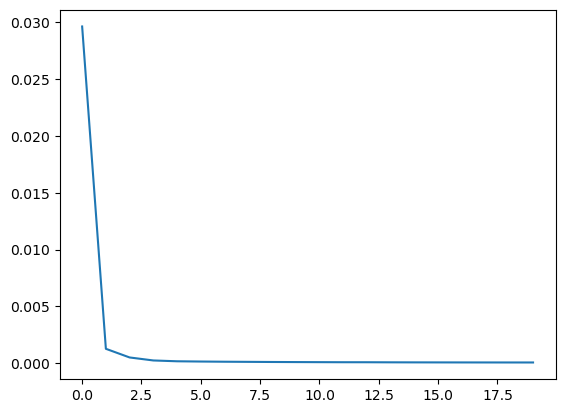

In [12]:
loss_per_epoch = model.history.history['loss']
#val_loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);
#plt.plot(range(len(val_loss_per_epoch)), val_loss_per_epoch)

In [13]:
last_train_batch = scaled_train[-n_input:] 
# take the last n_input month of values, to make 
# predictions on the 1st test set

In [14]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [15]:
#model.predict(last_train_batch)

y_pred = model.predict(generator)

st = scaled_train.shape[0]
yp = y_pred.shape[0]
c = st - yp
# Note: predictions start after 'n_input' numbers 

2368/2368 [==============================] - 37s 15ms/step


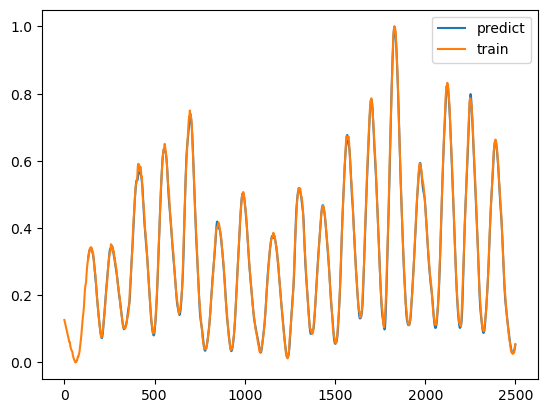

In [16]:
plt.plot(np.arange(c, st), y_pred, label='predict') 
plt.plot(scaled_train, label='train')
plt.legend();

#### Comment on plot:

The above plot shows how well our model fits with the training data. As the orange and blue lines almost completely overlap, we can conclude that the model accurately fits with the data. This is a necessary check, as our model will have no chance of predicting future sunspot numbers if it cannot successfully predict the training values.

In [17]:
validation_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(validation_data)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    validation_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 41ms/step


In [18]:
validation_predictions
# NOTE: these predictions are in the range 0-1
# we need to convert it back 

[array([0.05608998], dtype=float32),
 array([0.06020498], dtype=float32),
 array([0.06448121], dtype=float32),
 array([0.06891837], dtype=float32),
 array([0.07351878], dtype=float32),
 array([0.07828978], dtype=float32),
 array([0.08323962], dtype=float32),
 array([0.08837688], dtype=float32),
 array([0.09370988], dtype=float32),
 array([0.09924729], dtype=float32),
 array([0.10499778], dtype=float32),
 array([0.11097029], dtype=float32),
 array([0.11717417], dtype=float32),
 array([0.12361884], dtype=float32),
 array([0.13031438], dtype=float32),
 array([0.13727148], dtype=float32),
 array([0.14450145], dtype=float32),
 array([0.15200005], dtype=float32),
 array([0.15977487], dtype=float32),
 array([0.16783275], dtype=float32),
 array([0.17616495], dtype=float32),
 array([0.18475923], dtype=float32),
 array([0.19360879], dtype=float32),
 array([0.20270334], dtype=float32),
 array([0.21202834], dtype=float32),
 array([0.22156714], dtype=float32),
 array([0.2313031], dtype=float32),
 a

In [19]:
true_predictions = scaler.inverse_transform(validation_predictions)

In [20]:
validation_data['Predictions'] = true_predictions

/var/folders/42/2w7j46nn3j75crpy2kc1y7vw0000gn/T/ipykernel_29010/2311742674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Predictions'] = true_predictions


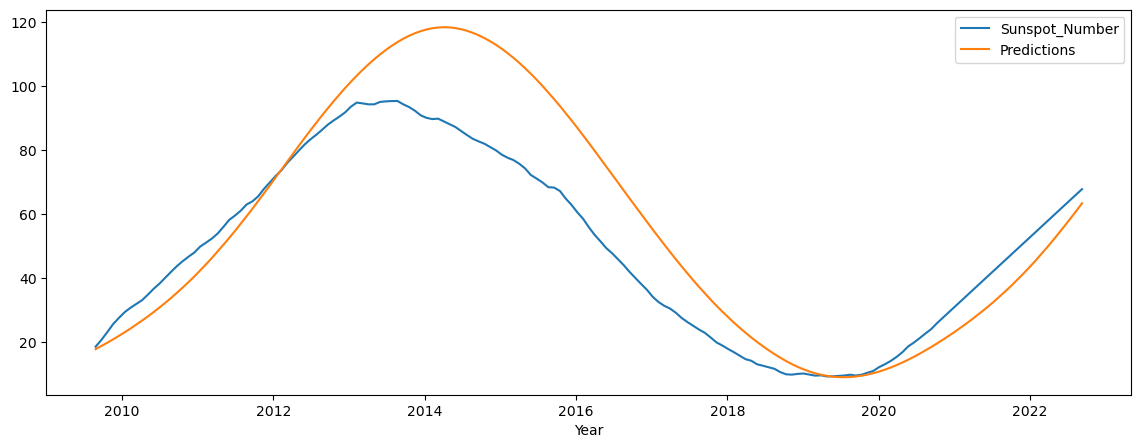

In [21]:
validation_data.plot(figsize=(14,5));

#### Comment on plot:

The predictions for future sunspot number seem to have a period which is close to the observed period (but not perfect), and the amplitude is still too high. I can try running again with more epochs or more neurons and see what happens.

**Edit**: run with 300 neurons produced a similar result to one with 200 neurons. Next I will try running with 200 neurons again, but for 100 epochs.